# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## 1. Import Dependencies

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

## 2. Data Preprocessing

In [2]:
data1 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="y", index_col=0)
data2 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x1", index_col=0)
data3 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x2", index_col=0)
data4 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x3", index_col=0)

y = np.array(data1)
x1 = np.array(data2)
x2 = np.array(data3)
x3 = np.array(data4)

data1_flat = data1.values.flatten()
data2_flat = data2.values.flatten()
data3_flat = data3.values.flatten()
data4_flat = data4.values.flatten()

In [38]:
data = pd.DataFrame({
    'y': data1_flat,
    'x1': data2_flat,
    'x2': data3_flat,
    'x3': data4_flat
})
data

,y,x1,x2,x3
0,17.08,-1.970,7.73,0.334
1,10.53,4.990,6.39,0.336
2,7.31,5.625,5.99,0.342
3,8.42,-1.035,6.72,0.364
4,8.86,4.555,2.73,0.361
...,...,...,...,...
573,11.49,4.775,3.04,0.351
574,16.42,5.780,6.08,0.288
575,6.46,19.460,4.60,0.300
576,20.49,3.020,5.53,0.370


## 3. Descriptive Stats

In [40]:
desc_stat = data.describe()
desc_stat

,y,x1,x2,x3
count,578.000000,578.000000,578.000000,578.000000
mean,10.814758,4.499152,5.055052,0.353097
std,5.638554,4.086967,1.805693,0.039766
min,3.420000,-21.300000,0.880000,0.236000
25%,6.387500,3.321250,3.720000,0.325000
50%,9.090000,5.075000,4.680000,0.351000
75%,13.845000,5.773750,6.170000,0.382000
max,28.540000,25.860000,10.950000,0.459000


In [41]:
writer = pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter')
with pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter') as writer:
    data.to_excel(writer, sheet_name='data', index=False)
    desc_stat.to_excel(writer, sheet_name='desc_stat')

## 4. ACF-PACF

<Figure size 1000x600 with 0 Axes>

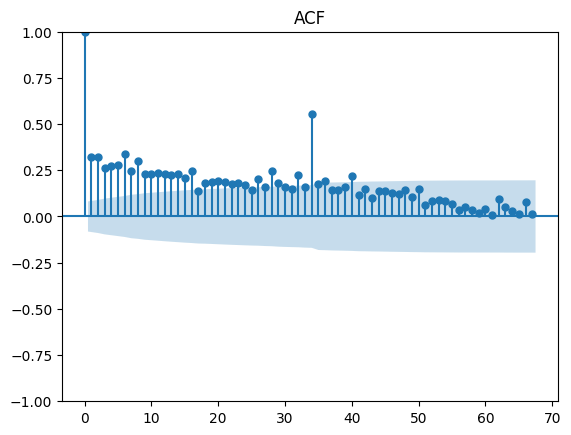

<Figure size 1000x600 with 0 Axes>

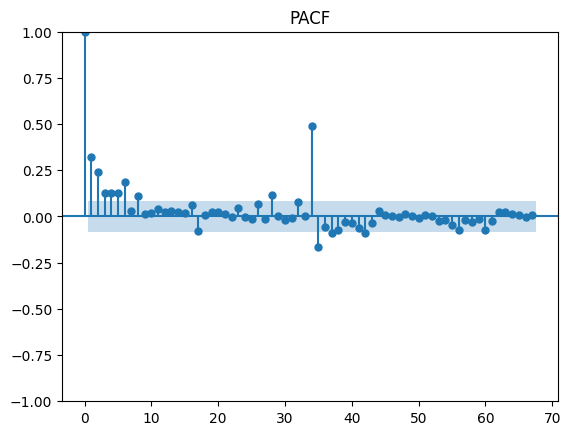

In [27]:
# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(data2_flat, lags=67)
plt.title(f'ACF')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(data2_flat, lags=67)
plt.title(f'PACF')
plt.show()

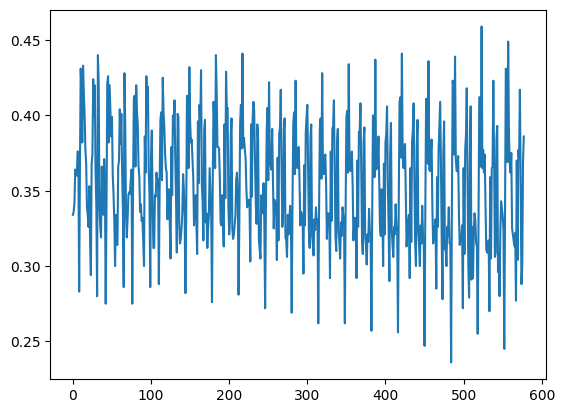

In [31]:
plt.plot(data4_flat)

In [33]:
# Fit AR model with 3 lags
model = AutoReg(data2_flat, lags=34)
fit = model.fit()

print(fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  578
Model:                    AutoReg(34)   Log Likelihood               -1361.856
Method:               Conditional MLE   S.D. of innovations              2.958
Date:                Sat, 18 May 2024   AIC                           2795.712
Time:                        04:24:58   BIC                           2950.474
Sample:                            34   HQIC                          2856.220
                                  578                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2892      0.293      0.988      0.323      -0.285       0.863
y.L1           0.1421      0.037      3.872      0.000       0.070       0.214
y.L2           0.0831      0.037      2.241      0.0

## 5. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

In [ ]:
import statsmodels.api as sm

# Perform ADF test
adf_test = sm.tsa.adfuller(data1_flat)

# Extracting the results
adf_statistic = adf_test[0]
p_value = adf_test[1]
used_lag = adf_test[2]
n_obs = adf_test[3]
critical_values = adf_test[4]
aic_value = adf_test[5]

# Printing the results with labels
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print(f"Number of Lags Used: {used_lag}")
print(f"Number of Observations Used: {n_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}: {value}")
print(f"AIC Value: {aic_value}")


## 6. Standarization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_norm = scaler.fit_transform(y)
x1_norm = scaler.fit_transform(x1)
x2_norm = scaler.fit_transform(x2)
x3_norm = scaler.fit_transform(x3)
y = y_norm.flatten()
x1_flat = x1_norm.flatten()
x2_flat = x2_norm.flatten()
x3_flat = x3_norm.flatten()
x = np.column_stack((x1_flat, x2_flat, x3_flat))

## 7. Data Splitting

In [ ]:
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

N_FEATURES = len(data.columns) # DO NOT CHANGE THIS
SPLIT_TIME = 443
x_train = data[:SPLIT_TIME]
x_test = data[SPLIT_TIME:]
tf.keras.backend.clear_session()
tf.random.set_seed(1)
BATCH_SIZE = 4
N_PAST = 34
N_FUTURE = 34
SHIFT = 1
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                            n_past=N_PAST, n_future=N_FUTURE,
                            shift=SHIFT)
test_set = windowed_dataset(series=x_test, batch_size=BATCH_SIZE,
                            n_past=N_PAST, n_future=N_FUTURE,
                            shift=SHIFT)

## 8. Neural Network Architecture

In [ ]:
#NN Parameter
input_node = 3
hidden_node = 6
output_node = 1

In [1]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(N_PAST, N_FEATURES)),
                tf.keras.layers.Dense(hidden_node, input_shape=(N_PAST, N_FEATURES), activation=activation),
                tf.keras.layers.Dense(N_FEATURES)
                ])
        model.compile(loss=loss_function, optimizer=optimizer)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset)
        if __name__ == '__main__':
                model.save(f"model_{hidden_node}.h5")
        final_loss = history.history['loss'][-1]
        weights = model.get_weights()
        return final_loss, weights[0], weights[1], weights[2], weights[3]

SyntaxError: positional argument follows keyword argument (3259101005.py, line 2)